### Importar Bibliotecas

In [77]:
import warnings

warnings.simplefilter("ignore", FutureWarning)

import sys
import os
import datetime

sys.path.append(os.path.join("..", ".."))
import toolkit as tk
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import f_oneway
from scipy.stats import zscore
import seaborn as sns
import numpy as np
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax
import plotly.subplots
from plotly.subplots import make_subplots
import plotly.offline as py
import plotly.graph_objs as go
import glob
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

from multiprocessing.pool import ThreadPool
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import random
from statsmodels.graphics.tsaplots import plot_acf

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import gc

## Instancias Reais

### Carregar DataFrame

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import MinMaxScaler
import random
import pandas as pd
import numpy as np

# 1. Obtenha as instâncias utilizando o (tk)
real_instances, simulated_instances, drawn_instances = tk.get_all_labels_and_files()

# Função para processar uma instância
def process_instance(instance):
    """Carrega, normaliza e reamostra uma instância."""
    try:
        # Carregar a instância
        df = tk.load_instance(instance)
        
        # Reamostrar para uma frequência de 1 minuto
        resampled_df = df.resample('T').first()
        
        # Selecionar colunas numéricas e aplicar normalização Min-Max
        numeric_columns = resampled_df.select_dtypes(include=['number']).columns
        excluded_columns = ['class', 'label', 'state']
        numeric_columns = numeric_columns.difference(excluded_columns)
        
        if not numeric_columns.empty:
            scaler = MinMaxScaler()
            resampled_df[numeric_columns] = scaler.fit_transform(resampled_df[numeric_columns])
        
        # Preencher valores nulos em 'class' e 'state' com 0
        resampled_df['class'] = resampled_df['class'].fillna(0)
        resampled_df['state'] = resampled_df['state'].fillna(0)
        
        # Criar coluna auxiliar 'class_1'
        resampled_df['class_1'] = resampled_df['class'].apply(lambda x: 0 if x == 0 else 1)
        
        return resampled_df
    
    except Exception as e:
        print(f"Erro ao processar {instance}: {e}")
        return None

# 2. Processar todas as instâncias em paralelo
aggregated_dfs = []
with ThreadPool() as pool:
    for normalized_df in pool.imap_unordered(
        lambda instance: process_instance(instance), real_instances
    ):
        if normalized_df is not None:
            aggregated_dfs.append(normalized_df)

# Verificar se há dados processados
if not aggregated_dfs:
    combined_aggregated_df = pd.DataFrame()
else:
    # 3. Criar dois grupos de instâncias (Grupo A e Grupo B)
    # Extrair o label de cada instância
    labels = [df['label'].iloc[0] for df in aggregated_dfs]

    # Dividir as instâncias entre Grupo A e Grupo B garantindo estratificado por 'label'
    group_a, group_b = [], []
    for label in set(labels):
        # Filtrar instâncias com o mesmo label
        labeled_dfs = [df for df, lbl in zip(aggregated_dfs, labels) if lbl == label]
        
        # Dividir igualmente entre os dois grupos
        a, b = train_test_split(labeled_dfs, test_size=0.5, random_state=42)
        group_a.extend(a)
        group_b.extend(b)

    # 4. Concatenar as instâncias dentro de cada grupo de forma aleatória
    random.shuffle(group_a)
    random.shuffle(group_b)

    group_a_df = pd.concat(group_a, ignore_index=False)
    group_b_df = pd.concat(group_b, ignore_index=False)

    # 5. Concatenar os dois grupos em um único DataFrame final
    combined_aggregated_df = pd.concat([group_a_df, group_b_df], ignore_index=True)

    # Ajustar o índice do DataFrame final para manter sequência temporal
    start_time = combined_aggregated_df.index.min()  # Obter o menor timestamp
    num_rows = combined_aggregated_df.shape[0]  # Número total de linhas
    new_index = pd.date_range(start=start_time, periods=num_rows, freq='T')  # Novo índice sequencial
    combined_aggregated_df.index = new_index

# Resultado final: `combined_aggregated_df` estratificados e concatenado

# Criar um DataFrame com os labels e os tamanhos de cada grupo
label_counts_a = group_a_df['label'].value_counts().sort_index()
label_counts_b = group_b_df['label'].value_counts().sort_index()

# Unir os dados em um único DataFrame para visualização
comparison_df = pd.DataFrame({
    'Labels': label_counts_a.index,
    'Grupo A': label_counts_a.values,
    'Grupo B': label_counts_b.values
})


comparison_df
# Verificar se o DataFrame não está vazio
if not combined_aggregated_df.empty:
    # Calcular a porcentagem de valores nulos por coluna
    null_percentage = combined_aggregated_df.isnull().mean()
    
    # Manter apenas as colunas com 60% ou menos de valores nulos
    filtered_columns = null_percentage[null_percentage <= 0.6].index
    combined_aggregated_df = combined_aggregated_df[filtered_columns]
    
    print("Colunas com mais de 60% de valores nulos foram removidas.")
else:
    print("O DataFrame está vazio.")


c:\Users\EZUN\Documents\powerbi_notebook\Notebook - SSUB Loc Recursos\ssublocenv\lib\site-packages\sklearn\utils\_array_api.py:701: RuntimeWarning:

All-NaN slice encountered

c:\Users\EZUN\Documents\powerbi_notebook\Notebook - SSUB Loc Recursos\ssublocenv\lib\site-packages\sklearn\utils\_array_api.py:718: RuntimeWarning:

All-NaN slice encountered

c:\Users\EZUN\Documents\powerbi_notebook\Notebook - SSUB Loc Recursos\ssublocenv\lib\site-packages\sklearn\utils\_array_api.py:701: RuntimeWarning:

All-NaN slice encountered

c:\Users\EZUN\Documents\powerbi_notebook\Notebook - SSUB Loc Recursos\ssublocenv\lib\site-packages\sklearn\utils\_array_api.py:718: RuntimeWarning:

All-NaN slice encountered

c:\Users\EZUN\Documents\powerbi_notebook\Notebook - SSUB Loc Recursos\ssublocenv\lib\site-packages\sklearn\utils\_array_api.py:701: RuntimeWarning:

All-NaN slice encountered

c:\Users\EZUN\Documents\powerbi_notebook\Notebook - SSUB Loc Recursos\ssublocenv\lib\site-packages\sklearn\utils\_array_

Colunas com mais de 60% de valores nulos foram removidas.


In [79]:
comparison_df

,Labels,Grupo A,Grupo B
0,0,99313,103889
1,1,1260,2692
2,2,2347,2288
3,3,5693,5754
4,4,30900,31036
5,5,2671,4662
6,6,315,980
7,7,72516,58610
8,8,39732,40432
9,9,23375,20598


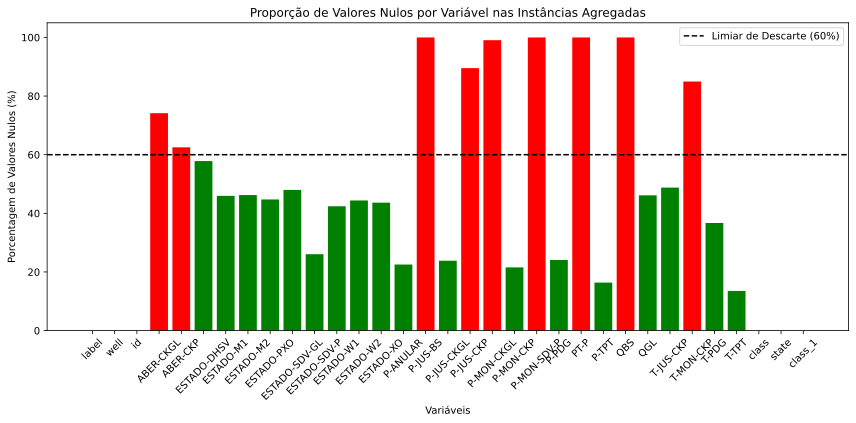

In [80]:
import matplotlib.pyplot as plt
import pandas as pd

# Concatenar as instâncias processadas
temp_df = pd.concat(aggregated_dfs, ignore_index=True)

# Calcular a porcentagem de valores nulos por coluna
null_percentage = temp_df.isnull().mean() * 100

# Criar o gráfico
plt.figure(figsize=(12, 6))
plt.bar(
    null_percentage.index,
    null_percentage.values,
    color=['red' if val > 60 else 'green' for val in null_percentage.values]
)
plt.axhline(60, color='black', linestyle='--', label='Limiar de Descarte (60%)')
plt.ylabel("Porcentagem de Valores Nulos (%)")
plt.xlabel("Variáveis")
plt.title("Proporção de Valores Nulos por Variável nas Instâncias Agregadas")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
# Verificar se o DataFrame não está vazio
if not combined_aggregated_df.empty:
    # Exibir os tipos de cada coluna
    column_types = combined_aggregated_df.dtypes
    
    # Exibir o tipo do índice
    index_type = combined_aggregated_df.index.dtype
    
    # Imprimir os resultados
    print("Tipos das colunas:")
    print(column_types)
    print("\nTipo do índice:")
    print(index_type)
else:
    print("O DataFrame está vazio.")


Tipos das colunas:
label              int64
well              object
id                object
ESTADO-DHSV      float64
ESTADO-M1        float64
ESTADO-M2        float64
ESTADO-PXO       float64
ESTADO-SDV-GL    float64
ESTADO-SDV-P     float64
ESTADO-W1        float64
ESTADO-W2        float64
ESTADO-XO        float64
P-ANULAR         float64
P-JUS-CKGL       float64
P-MON-CKP        float64
P-PDG            float64
P-TPT            float64
QGL              float64
T-JUS-CKP        float64
T-PDG            float64
T-TPT            float64
class              Int16
state              Int16
class_1            int64
dtype: object

Tipo do índice:
datetime64[ns]


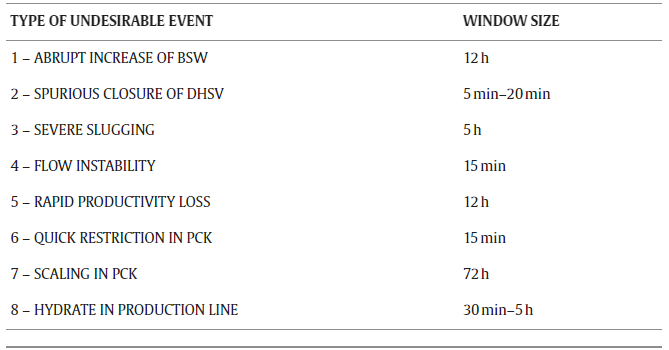

# Classificação Plana

## LSTM Model

In [49]:
combined_aggregated_df["class"].unique()

<IntegerArray>
[0, 4, 102, 2, 107, 108, 8, 105, 5, 109, 101, 1, 3, 106, 6, 9, 7]
Length: 17, dtype: Int16

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm 
import time
from scipy.stats import sem, t 

# 1. Preparação dos Dados
columns_to_exclude = ['label', 'well', 'id', 'state', 'class', 'class_1']

# Criar a variável class_2
combined_aggregated_df['class_2'] = combined_aggregated_df['class'] % 100

# Mapear valores únicos de 'class_2' para índices contínuos
unique_classes = sorted(combined_aggregated_df['class_2'].unique())  # Valores únicos ordenados
class_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}  # Mapeamento {valor_original: índice_contínuo}
combined_aggregated_df['class_2'] = combined_aggregated_df['class_2'].map(class_mapping)  # Aplicar o mapeamento aos dados

# Atualizar os dados para excluir 'class' e 'class_1'
data = combined_aggregated_df.drop(columns=columns_to_exclude)

# Definindo a variável alvo
target = 'class_2' 

# Certificar que todas as colunas em features são numéricas
features = [col for col in data.columns if col != target and np.issubdtype(data[col].dtype, np.number)]
features_test = [col for col in data.columns if col not in [target, 'class_1'] and np.issubdtype(data[col].dtype, np.number)]

# Converter os dados para float32
data[features] = data[features].astype(np.float32)

# valores nulos no DataFrame (se houver)
data.fillna(data.mean(), inplace=True)

# Dividir os dados em treino e teste (50% para treino e 50% para teste = Grupo_A e Grupo_B)
train_size = int(0.5 * len(data))
train = data[:train_size]
test = data[train_size:]


# 2. Criar Matrizes para Modelos Sequenciais (Janela Deslizante) com Validação
def create_sequences(data, target_col, seq_length):
    """
    Cria sequências temporais para modelos sequenciais (LSTM).
    """
    X, y = [], []
    for i in tqdm(range(len(data) - seq_length), desc="Criando sequências"):
        X.append(data.iloc[i:i + seq_length].values)
        y.append(data.iloc[i + seq_length][target_col])
    X = np.array(X, dtype=np.float32)  # Garantir tipo float32
    y = np.array(y, dtype=np.int32)    # Garantir tipo int32 para o alvo
    
    return X, y

seq_length = 15
X_train_seq, y_train_seq = create_sequences(train[features + [target]], target_col=target, seq_length=seq_length)
X_test_seq, y_test_seq = create_sequences(test[features_test + [target]], target_col=target, seq_length=seq_length)

# Determinar o número de features diretamente
num_features = X_train_seq.shape[2] 

# Ajustar o redimensionamento dinamicamente
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], seq_length, num_features))
X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], seq_length, num_features))

# 3. Criar o Modelo LSTM
def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Camada de entrada explícita
    model.add(LSTM(32, activation='relu', return_sequences=True))  # Retornar a sequência completa
    model.add(LSTM(64, activation='relu'))  # Apenas a saída final
    model.add(Dense(num_classes, activation='softmax'))  # Saída para múltiplas classes
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

num_classes = len(unique_classes)
input_shape = (seq_length, num_features)
model_mult = create_lstm_model(input_shape, num_classes)

# 4. Treinar o Modelo LSTM
start_time = time.time()
with tqdm(total=1, desc="Treinando o modelo") as pbar:
    model_mult.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, verbose=0)
    pbar.update(1)
training_time = time.time() - start_time
print(f"Treinamento concluído em {training_time:.2f} segundos.")


Treinando o modelo: 100%|██████████| 1/1 [19:34<00:00, 1174.90s/it]

Treinamento concluído em 1174.90 segundos.



Resultados Finais do Modelo (Multiclasse - Otimizado):
Precision (macro): 0.826
Recall (macro): 0.783
F1-Score (macro): 0.788
Tempo médio de previsão por janela: 0.000088 segundos


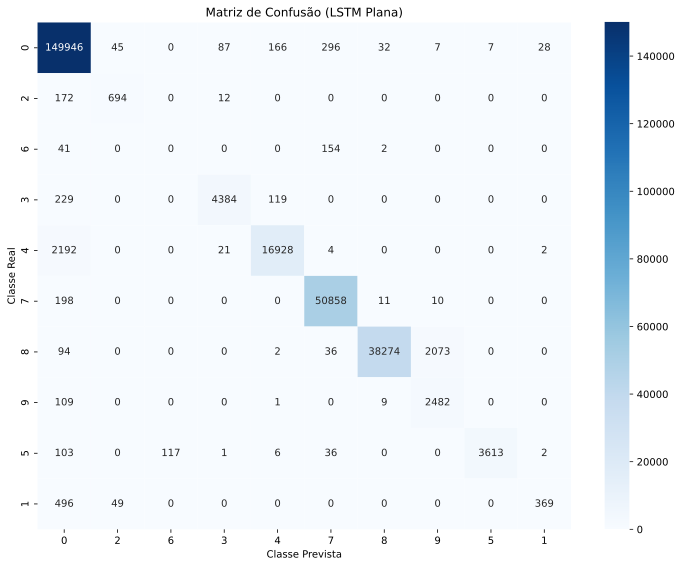

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

# Fazer predições
start_time = time.time()
y_pred_probs = model_mult.predict(X_test_seq, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
end_time = time.time()

# Tempo médio por janela
avg_time = (end_time - start_time) / len(X_test_seq)

# Calcular métricas
precision = precision_score(y_test_seq, y_pred_classes, average='macro', zero_division=0)
recall = recall_score(y_test_seq, y_pred_classes, average='macro', zero_division=0)
f1 = f1_score(y_test_seq, y_pred_classes, average='macro', zero_division=0)

# Imprimir resultados
print("\nResultados Finais do Modelo (Multiclasse - Otimizado):")
print(f"Precision (macro): {precision:.3f}")
print(f"Recall (macro): {recall:.3f}")
print(f"F1-Score (macro): {f1:.3f}")
print(f"Tempo médio de previsão por janela: {avg_time:.6f} segundos")

# Gerar matriz de confusão com ordem personalizada
nova_ordem = [0, 2, 6, 3, 4, 7, 8, 9, 5, 1]
conf_matrix = confusion_matrix(y_test_seq, y_pred_classes, labels=nova_ordem)

# Visualizar matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=nova_ordem, yticklabels=nova_ordem)
plt.title('Matriz de Confusão (LSTM Plana)')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.tight_layout()
plt.show()


# Modelo Hierárquico

### Definição dos Níveis

In [ ]:
mapa_nivel1 = {
    0: 0, #'Operação Normal',
    1: 5,#'Falha Contaminante',
    2: 1, #'Falha Mecânica',
    3: 2, #'Falha Hidráulica',
    4: 2, #'Falha Hidráulica',
    5: 4, #'Falha Produtiva',
    6: 1, #'Falha Mecânica',
    7: 3, #'Falha Química',
    8: 3, #'Falha Química',
    9: 3, #'Falha Química' 
}


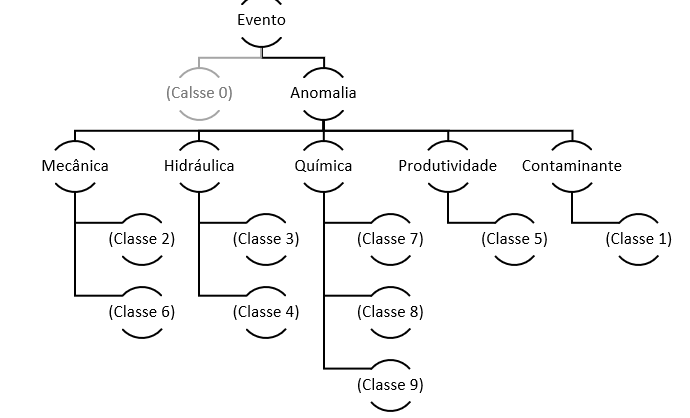

In [82]:
# Nível 0 - falha e normal
combined_aggregated_df.rename(columns={'class_1': 'nivel_0'}, inplace=True)

In [83]:
combined_aggregated_df['nivel_2'] = combined_aggregated_df['class'] % 100

In [84]:
combined_aggregated_df['nivel_1'] = combined_aggregated_df['nivel_2'].map(mapa_nivel1)

## Classificação Nível 0

### WindowSizw -> 15

In [85]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tqdm import tqdm

# 1. Preparação dos Dados
columns_to_exclude = ['label', 'well', 'id', 'state', 'class', 'nivel_1', 'nivel_2']  # Colunas irrelevantes
data = combined_aggregated_df.drop(columns=columns_to_exclude)

target = 'nivel_0'  # Definindo a variável alvo

# valores nulos no DataFrame (se houver)
data.fillna(data.mean(), inplace=True)

# Dividir os dados em treino e teste (50% para treino e 50% para teste)
train_size = int(0.5 * len(data))
train = data[:train_size]
test = data[train_size:]

# Separar features e target
features = [col for col in data.columns if col != target]
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# 2. Criar Matrizes para Modelos Sequenciais (Janela Deslizante)
def create_sequences(data, target_col, seq_length):
    """
    Cria sequências temporais para modelos sequenciais (LSTM).
    """
    X, y = [], []
    for i in tqdm(range(len(data) - seq_length), desc="Criando sequências"):
        X.append(data.iloc[i:i + seq_length].values)  # Janela de sequência
        y.append(data.iloc[i + seq_length][target_col])  # Alvo correspondente
    return np.array(X), np.array(y)

################################
#       Tamanho da Janela      #
################################
seq_length = 15

X_train_seq, y_train_seq = create_sequences(train[features + [target]], target_col=target, seq_length=seq_length)
X_test_seq, y_test_seq = create_sequences(test[features + [target]], target_col=target, seq_length=seq_length)

num_features = X_train_seq.shape[2]

# Ajustar as sequências
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], seq_length, num_features))
X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], seq_length, num_features))

# 3. Criar Métrica Personalizada para Recall da Classe 1
def recall_nivel_0(y_true, y_pred):
    """
    Calcula o recall para a classe 1.
    """
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred > 0.5, 'float32')  # Usa limiar 0.5 como padrão
    true_positives = K.sum(y_true * y_pred)  # TP: Predições corretas para a classe 1
    possible_positives = K.sum(y_true)  # Todos os valores reais da classe 1
    recall = true_positives / (possible_positives + K.epsilon())  # Evita divisão por zero
    return recall

# 4. Ajustar os Pesos das Classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),  # Corrigido: Convertido para numpy.ndarray
    y=y_train_seq
)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}  # Pesos como dicionário
print(f"Pesos de classe: {class_weights_dict}")

# 5. Criar o Modelo LSTM
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=input_shape))
    model.add(Dense(64, activation='relu')) 
    model.add(Dense(1, activation='sigmoid'))  # Saída binária
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[recall_nivel_0])
    return model

input_shape = (seq_length, num_features)
model_bin = create_lstm_model(input_shape)

# Adicionar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 6. Treinar o Modelo LSTM
model_bin.fit(
    X_train_seq, y_train_seq, 
    epochs=20, 
    batch_size=32, 
    validation_split=0.2,  # Usar parte dos dados de treino para validação
    class_weight=class_weights_dict,  # Inclui os pesos das classes
    callbacks=[early_stopping],
    verbose=1
)

model_bin.save("modelo_multinivel_lstm_N0.h5")

Criando sequências: 100%|██████████| 274517/274517 [01:03<00:00, 4326.15it/s]
c:\Users\EZUN\Documents\powerbi_notebook\Notebook - SSUB Loc Recursos\ssublocenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Pesos de classe: {0: np.float64(0.9276194852941176), 1: np.float64(1.084631918323482)}
Epoch 1/20
6863/6863 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - loss: 0.0438 - recall_nivel_0: 13.3958 - val_loss: 0.0108 - val_recall_nivel_0: 19.8357
Epoch 2/20
6863/6863 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - loss: 0.0147 - recall_nivel_0: 13.4657 - val_loss: 0.0101 - val_recall_nivel_0: 19.8357
Epoch 3/20
6863/6863 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 0.0142 - recall_nivel_0: 13.5533 - val_loss: 0.0107 - val_recall_nivel_0: 19.8357
Epoch 4/20
6863/6863 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - loss: 0.0148 - recall_nivel_0: 13.4166 - val_loss: 0.0109 - val_recall_nivel_0: 19.8357
Epoch 5/20
6863/6863 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - loss: 0.0128 - recall_nivel_0: 13.5074 - val_loss: 0.0101 - val_recall_nivel_0: 19.8357
Epoch 6/20
6863/6863 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - loss: 0.0128 - recall_nivel_0: 13.5127 - val_loss: 0.0099 - val_recall_nivel_0: 19.8357
Epoch 7/20
6863/6863 ━━━━━━━━━━━━━━━━━━━━ 5

8579/8579 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step

Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    162688
         1.0       1.00      1.00      1.00    111829

    accuracy                           1.00    274517
   macro avg       1.00      1.00      1.00    274517
weighted avg       1.00      1.00      1.00    274517


Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    162688
         1.0       1.00      1.00      1.00    111829

    accuracy                           1.00    274517
   macro avg       1.00      1.00      1.00    274517
weighted avg       1.00      1.00      1.00    274517



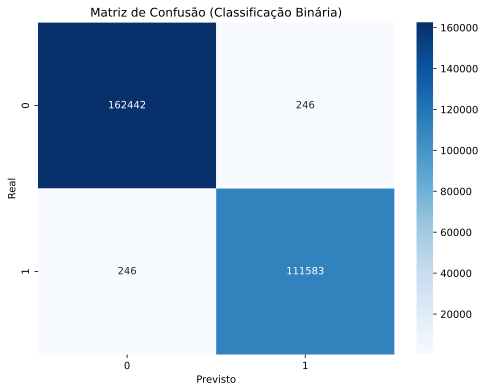


Resultados Finais do Modelo (Classificação Binária):
Precision (macro): 0.998
Recall (macro): 0.998
F1-Score (macro): 0.998
Tempo médio de previsão por janela: 0.000090 segundos


In [86]:
from tensorflow.keras.models import load_model

model_bin = load_model("modelo_multinivel_lstm_N0.h5", custom_objects={'recall_nivel_0': recall_nivel_0})

# 7. Ajustar o Limiar para Predições
threshold = 0.3  # Limiar ajustado para melhorar recall da classe 1
y_pred_adjusted = (model_bin.predict(X_test_seq) > threshold).astype(int)

# 8. Avaliar o Modelo Ajustado
print("\nRelatório de Classificação:")
print(classification_report(y_test_seq, y_pred_adjusted, zero_division=0))

from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

# 5. Fazer Previsões em Lote com Janelas Deslizantes
def sliding_window_predictions(model, X_test_seq, y_test_seq):
    """
    Realiza predições em lote e retorna as métricas finais e as previsões.
    """
    start_time = time.time()  # Marca o início do processo de previsão

    # Realiza predições para todas as sequências em um único passo
    y_pred_probs = model.predict(X_test_seq, verbose=0)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Aplicar o limiar de decisão

    end_time = time.time()  # Marca o fim do processo de previsão
    avg_time = (end_time - start_time) / len(X_test_seq)  # Tempo médio por previsão

    return y_pred, avg_time

# Chamada da função de previsão em lote
y_pred_nivel_0, avg_time = sliding_window_predictions(model_bin, X_test_seq, y_test_seq)

# Relatório de Classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test_seq, y_pred_nivel_0, zero_division=0))

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test_seq, y_pred_nivel_0)

# Visualização da Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Matriz de Confusão (Classificação Binária)")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

# Calcular Intervalos de Confiança para Métricas Gerais
def confidence_interval(metric_scores, confidence=0.95):
    """
    Calcula intervalos de confiança para métricas.
    """
    n = len(metric_scores)
    mean = np.mean(metric_scores)
    error = sem(metric_scores)
    interval = t.ppf((1 + confidence) / 2., n - 1) * error
    return mean, mean - interval, mean + interval

precision_macro = precision_score(y_test_seq, y_pred_nivel_0, average='macro', zero_division=0)
recall_macro = recall_score(y_test_seq, y_pred_nivel_0, average='macro', zero_division=0)
f1_macro = f1_score(y_test_seq, y_pred_nivel_0, average='macro', zero_division=0)

# Exibir resultados ajustados
print("\nResultados Finais do Modelo (Classificação Binária):")
print(f"Precision (macro): {precision_macro:.3f}")
print(f"Recall (macro): {recall_macro:.3f}")
print(f"F1-Score (macro): {f1_macro:.3f}")
print(f"Tempo médio de previsão por janela: {avg_time:.6f} segundos")


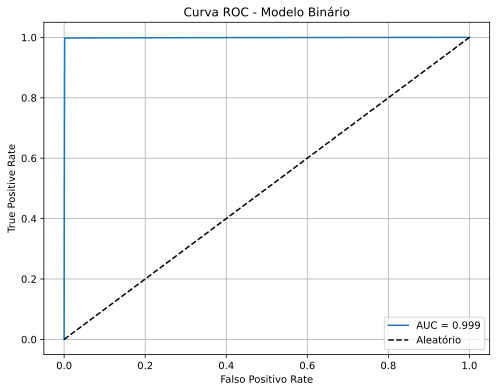


AUC da Curva ROC: 0.999


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Recalcular probabilidades sem threshold para AUC
y_pred_probs_full = model_bin.predict(X_test_seq, verbose=0).flatten()

# Calcular ROC
fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_probs_full)
auc_score = roc_auc_score(y_test_seq, y_pred_probs_full)

# Plotar a Curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0,1], [0,1], 'k--', label='Aleatório')
plt.xlabel("Falso Positivo Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Modelo Binário")
plt.legend()
plt.grid(True)
plt.show()

# Mostrar AUC no console também
print(f"\nAUC da Curva ROC: {auc_score:.3f}")


## Classificação Nível 1

In [88]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm  # Biblioteca para monitoramento do progresso
import time
from scipy.stats import sem, t  # Biblioteca para cálculo de intervalos de confiança

# 1. Preparação dos Dados
columns_to_exclude = ['label', 'well', 'id', 'state', 'class', 'nivel_2']  # Colunas irrelevantes, vazamento de info

# Mapear valores únicos de 'nivel_2' para índices contínuos
unique_classes = sorted(combined_aggregated_df['nivel_1'].unique())  # Valores únicos ordenados
class_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}  # Mapeamento {valor_original: índice_contínuo}
combined_aggregated_df['nivel_1'] = combined_aggregated_df['nivel_1'].map(class_mapping)  # Aplicar o mapeamento aos dados

# Atualizar os dados para excluir 'class' e 'class_1'
data = combined_aggregated_df.drop(columns=columns_to_exclude)

target = 'nivel_1'  # Definindo a variável alvo

# Certificar que todas as colunas em features são numéricas
features = [col for col in data.columns if col != target and np.issubdtype(data[col].dtype, np.number)]
features_test = [col for col in data.columns if col not in [target, 'nivel_2'] and np.issubdtype(data[col].dtype, np.number)]

# Converter os dados para float32
data[features] = data[features].astype(np.float32)

# valores nulos no DataFrame (se houver)
data.fillna(data.mean(), inplace=True)

# Dividir os dados em treino e teste (50% para treino e 50% para teste)
train_size = int(0.5 * len(data))
train = data[:train_size]
test = data[train_size:]
test['nivel_0'] = [1] * seq_length + list(y_pred_nivel_0)

# 2. Criar Matrizes para Modelos Sequenciais (Janela Deslizante) com Validação
def create_sequences(data, target_col, seq_length):
    """
    Cria sequências temporais para modelos sequenciais (LSTM).
    """
    X, y = [], []
    for i in tqdm(range(len(data) - seq_length), desc="Criando sequências"):
        X.append(data.iloc[i:i + seq_length].values)
        y.append(data.iloc[i + seq_length][target_col])
    X = np.array(X, dtype=np.float32)  # Garantir tipo float32
    y = np.array(y, dtype=np.int32)    # Garantir tipo int32 para o alvo
    
    return X, y

seq_length = 15
X_train_seq, y_train_seq = create_sequences(train[features + [target]], target_col=target, seq_length=seq_length)
X_test_seq, y_test_seq = create_sequences(test[features_test + [target]], target_col=target, seq_length=seq_length)

# Determinar o número de features diretamente
num_features = X_train_seq.shape[2]  # Dimensão atual das features

# Ajustar o redimensionamento dinamicamente
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], seq_length, num_features))
X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], seq_length, num_features))

# 3. Criar o Modelo LSTM
def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Camada de entrada explícita
    model.add(LSTM(32, activation='relu', return_sequences=True))  # Retornar a sequência completa
    model.add(LSTM(64, activation='relu'))  # Apenas a saída final
    model.add(Dense(num_classes, activation='softmax'))  # Saída para múltiplas classes
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

num_classes = len(unique_classes)
input_shape = (seq_length, num_features)
model_mult = create_lstm_model(input_shape, num_classes)

# Adicionar callback de EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',     # Critério para interrupção
    patience=3,             # Número de épocas sem melhora para parar
    restore_best_weights=True  # Recupera os melhores pesos
)



# 4. Treinar o Modelo LSTMTreinar o modelo com validação e EarlyStopping
start_time = time.time()
with tqdm(total=1, desc="Treinando o modelo") as pbar:
    model_mult.fit(
        X_train_seq,
        y_train_seq,
        epochs=20,
        batch_size=32,
        validation_split=0.2,      # Separação automática de parte do treino para validação
        callbacks=[early_stopping],
        verbose=1
    )
    pbar.update(1)
training_time = time.time() - start_time
print(f"Treinamento concluído em {training_time:.2f} segundos.")


model_mult.save("modelo_multinivel_lstm_N1.h5")

C:\Users\EZUN\AppData\Local\Temp\ipykernel_7748\1287514334.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

Treinando o modelo:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/20
6863/6863 ━━━━━━━━━━━━━━━━━━━━ 108s 15ms/step - accuracy: 0.9775 - loss: 0.0925 - val_accuracy: 0.9977 - val_loss: 0.0223
Epoch 2/20
6863/6863 ━━━━━━━━━━━━━━━━━━━━ 103s 15ms/step - accuracy: 0.9975 - loss: 0.0179 - val_accuracy: 0.9964 - val_loss: 0.0173
Epoch 3/20
6863/6863 ━━━━━━━━━━━━━━━━━━━━ 104s 15ms/step - accuracy: 0.9970 - loss: 0.0197 - val_accuracy: 0.9930 - val_loss: 0.0507
Epoch 4/20
6863/6863 ━━━━━━━━━━━━━━━━━━━━ 103s 15ms/step - accuracy: 0.9978 - loss: 0.0151 - val_accuracy: 0.9956 - val_loss: 0.0246
Epoch 5/20
6863/6863 ━━━━━━━━━━━━━━━━━━━━ 104s 15ms/step - accuracy: 0.9978 - loss: 0.0365 - val_accuracy: 0.9985 - val_loss: 0.0108
Epoch 6/20
6863/6863 ━━━━━━━━━━━━━━━━━━━━ 106s 15ms/step - accuracy: 0.9979 - loss: 0.0142 - val_accuracy: 0.9985 - val_loss: 0.0104
Epoch 7/20
6863/6863 ━━━━━━━━━━━━━━━━━━━━ 110s 16ms/step - accuracy: 0.9979 - loss: 0.0138 - val_accuracy: 0.9973 - val_loss: 0.0116
Epoch 8/20
6863/6863 ━━━━━━━━━━━━━━━━━━━━ 101s 15ms/step - accuracy: 

Treinando o modelo: 100%|██████████| 1/1 [15:36<00:00, 936.29s/it]


Treinamento concluído em 936.30 segundos.



Resultados Finais do Modelo (Multiclasse - Otimizado):
Precision (macro): 0.987
Recall (macro): 0.992
F1-Score (macro): 0.990
Tempo médio de previsão por janela: 0.000111 segundos


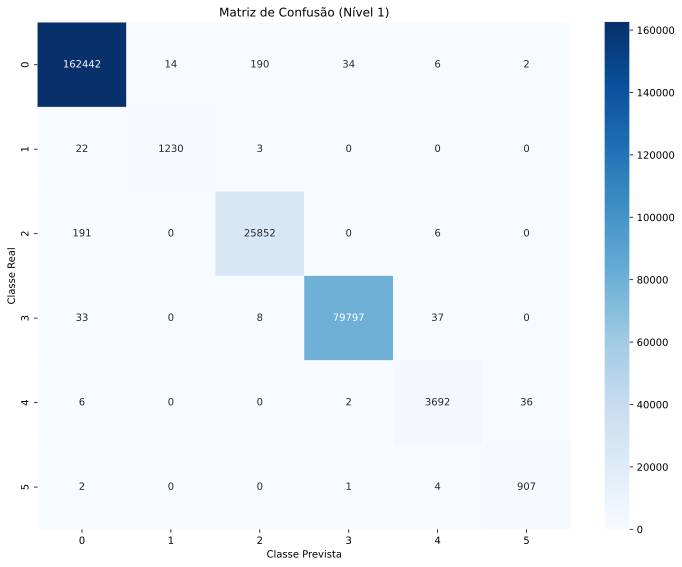

In [90]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

# Fazer predições no conjunto de teste
start_time = time.time()
y_pred_probs = model_mult.predict(X_test_seq, verbose=0)
y_pred_nivel_1 = np.argmax(y_pred_probs, axis=1)
end_time = time.time()

# Calcular tempo médio de previsão por janela
avg_time = (end_time - start_time) / len(X_test_seq)

# Calcular métricas de avaliação
precision = precision_score(y_test_seq, y_pred_nivel_1, average='macro', zero_division=0)
recall = recall_score(y_test_seq, y_pred_nivel_1, average='macro', zero_division=0)
f1 = f1_score(y_test_seq, y_pred_nivel_1, average='macro', zero_division=0)

# Imprimir os resultados das métricas
print("\nResultados Finais do Modelo (Multiclasse - Otimizado):")
print(f"Precision (macro): {precision:.3f}")
print(f"Recall (macro): {recall:.3f}")
print(f"F1-Score (macro): {f1:.3f}")
print(f"Tempo médio de previsão por janela: {avg_time:.6f} segundos")

# Criar e exibir matriz de confusão com ordem personalizada de classes
nova_ordem = [0, 1,2,3,4,5]
conf_matrix = confusion_matrix(y_test_seq, y_pred_nivel_1, labels=nova_ordem)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=nova_ordem, yticklabels=nova_ordem)
plt.title('Matriz de Confusão (Nível 1)')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.tight_layout()
plt.show()




AUC por classe:
Classe 0: AUC = 0.999
Classe 1: AUC = 0.998
Classe 2: AUC = 0.998
Classe 3: AUC = 1.000
Classe 4: AUC = 1.000
Classe 5: AUC = 0.999

AUC Macro (média): 0.999


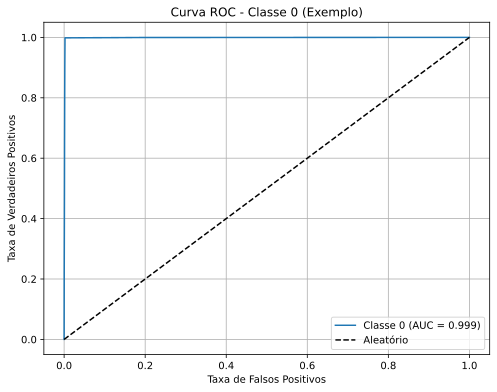

In [93]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Binarizar as classes reais
classes = np.unique(y_test_seq)
y_test_binarized = label_binarize(y_test_seq, classes=classes)

# Calcular AUC para cada classe (One-vs-Rest)
auc_per_class = {}
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    auc_score = auc(fpr, tpr)
    auc_per_class[class_label] = auc_score

# Calcular AUC Macro
macro_auc = roc_auc_score(y_test_binarized, y_pred_probs, average="macro")

# Exibir resultados
print("\nAUC por classe:")
for cls, score in auc_per_class.items():
    print(f"Classe {cls}: AUC = {score:.3f}")

print(f"\nAUC Macro (média): {macro_auc:.3f}")

# Opcional: Plotar Curva ROC de uma das classes (por exemplo, Classe 0)
plt.figure(figsize=(8,6))
fpr, tpr, _ = roc_curve(y_test_binarized[:, 0], y_pred_probs[:, 0])
plt.plot(fpr, tpr, label=f'Classe {classes[0]} (AUC = {auc_per_class[classes[0]]:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Aleatório')
plt.xlabel("Taxa de Falsos Positivos")
plt.ylabel("Taxa de Verdadeiros Positivos")
plt.title("Curva ROC - Classe 0 (Exemplo)")
plt.legend()
plt.grid(True)
plt.show()


C:\Users\EZUN\AppData\Local\Temp\ipykernel_17292\501490249.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

Criando sequências: 100%|██████████| 274517/274517 [00:58<00:00, 4719.64it/s]


Epoch 1/20
6863/6863 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step - accuracy: 0.9880 - loss: 0.0629 - val_accuracy: 0.9976 - val_loss: 0.0166
Epoch 2/20
6863/6863 ━━━━━━━━━━━━━━━━━━━━ 51s 7ms/step - accuracy: 0.9977 - loss: 0.0162 - val_accuracy: 0.9980 - val_loss: 0.0146
Epoch 3/20
6863/6863 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - accuracy: 0.9981 - loss: 0.0137 - val_accuracy: 0.9980 - val_loss: 0.0153
Epoch 4/20
6863/6863 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - accuracy: 0.9980 - loss: 0.0168 - val_accuracy: 0.9981 - val_loss: 0.0148
Epoch 5/20
6863/6863 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - accuracy: 0.9983 - loss: 0.2432 - val_accuracy: 0.9980 - val_loss: 0.0148
Treinamento concluído em 253.78 segundos.

Resultados Finais do Modelo (Macro - sem classe 0):
Precision: 0.833
Recall: 0.815
F1-Score: 0.824
Tempo médio de previsão por janela: 0.000080 segundos


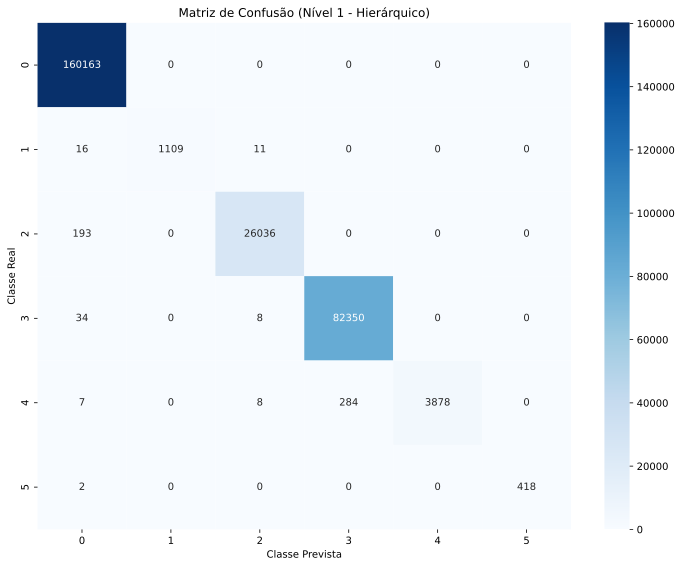

In [21]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. Ajustar features e preparar dados ---

# Define as colunas a excluir
columns_to_exclude = ['label', 'well', 'id', 'state', 'class', 'nivel_2']

# Garante mapeamento contínuo para variável target (nivel_1)
unique_classes = sorted(combined_aggregated_df['nivel_1'].unique())
class_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}
combined_aggregated_df['nivel_1'] = combined_aggregated_df['nivel_1'].map(class_mapping)

# Remove colunas desnecessárias e define target
data = combined_aggregated_df.drop(columns=columns_to_exclude)
target = 'nivel_1'

# Define features como todas as colunas numéricas, exceto o target
features = [col for col in data.columns if col != target and np.issubdtype(data[col].dtype, np.number)]
features_test = features  # garante consistência

# Converte para float32 e preenche nulos
data[features] = data[features].astype(np.float32)
data.fillna(data.mean(), inplace=True)

# Divide entre treino e teste
seq_length = 15
train_size = int(0.5 * len(data))
train = data[:train_size]
test = data[train_size:]
test['nivel_0'] = [1] * seq_length + list(y_pred_nivel_0)

# --- 2. Criar sequências temporais ---
def create_sequences(data, target_col, seq_length):
    X, y = [], []
    for i in tqdm(range(len(data) - seq_length), desc="Criando sequências"):
        X.append(data.iloc[i:i + seq_length].values)
        y.append(data.iloc[i + seq_length][target_col])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.int32)

X_train_seq, y_train_seq = create_sequences(train[features + [target]], target_col=target, seq_length=seq_length)
X_test_seq, y_test_seq = create_sequences(test[features + [target]], target_col=target, seq_length=seq_length)

# Ajusta forma das matrizes
num_features = X_train_seq.shape[2]
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], seq_length, num_features))
X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], seq_length, num_features))

# --- 3. Criar e treinar modelo LSTM ---
def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

num_classes = len(unique_classes)
model_mult = create_lstm_model((seq_length, num_features), num_classes)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()
model_mult.fit(
    X_train_seq, y_train_seq,
    epochs=20, batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)
training_time = time.time() - start_time
print(f"Treinamento concluído em {training_time:.2f} segundos.")

# --- 4. Avaliação com ajuste de classe 0 ---
start_time = time.time()
y_pred_probs = model_mult.predict(X_test_seq, verbose=0)
y_pred_nivel_1 = np.argmax(y_pred_probs, axis=1)
end_time = time.time()
avg_time = (end_time - start_time) / len(X_test_seq)

# Garante que se a classe real for 0, a prevista também seja 0
y_pred_nivel_1 = np.where(y_test_seq == 0, 0, y_pred_nivel_1)

# Filtra para avaliação somente onde classe real é diferente de 0
mask = y_test_seq != 0
precision = precision_score(y_test_seq[mask], y_pred_nivel_1[mask], average='macro', zero_division=0)
recall = recall_score(y_test_seq[mask], y_pred_nivel_1[mask], average='macro', zero_division=0)
f1 = f1_score(y_test_seq[mask], y_pred_nivel_1[mask], average='macro', zero_division=0)

print("\nResultados Finais do Modelo (Macro - sem classe 0):")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"Tempo médio de previsão por janela: {avg_time:.6f} segundos")

# --- 5. Matriz de Confusão ---
nova_ordem = sorted(set(y_test_seq))  # ou defina manualmente
conf_matrix = confusion_matrix(y_test_seq, y_pred_nivel_1, labels=nova_ordem)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=nova_ordem, yticklabels=nova_ordem)
plt.title('Matriz de Confusão (Nível 1 - Hierárquico)')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.tight_layout()
plt.show()



Resultados Finais do Modelo (Macro - sem classe 0):
Precision: 0.999
Recall: 0.982
F1-Score: 0.990
Tempo médio de previsão por janela: 0.000080 segundos


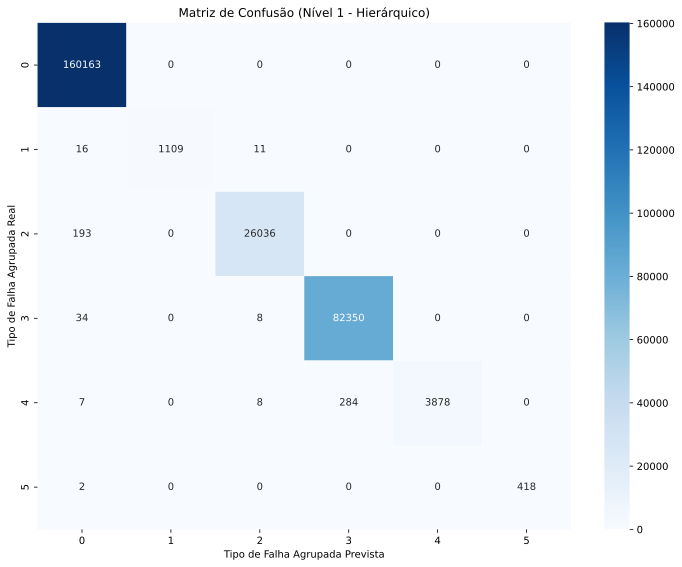

In [24]:
precision = precision_score(y_test_seq, y_pred_nivel_1, average='macro', zero_division=0)
recall = recall_score(y_test_seq, y_pred_nivel_1, average='macro', zero_division=0)
f1 = f1_score(y_test_seq, y_pred_nivel_1, average='macro', zero_division=0)

print("\nResultados Finais do Modelo (Macro - sem classe 0):")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"Tempo médio de previsão por janela: {avg_time:.6f} segundos")

# --- 5. Matriz de Confusão ---
nova_ordem = sorted(set(y_test_seq))  # ou defina manualmente
conf_matrix = confusion_matrix(y_test_seq, y_pred_nivel_1, labels=nova_ordem)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=nova_ordem, yticklabels=nova_ordem)
plt.title('Matriz de Confusão (Nível 1 - Hierárquico)')
plt.xlabel('Tipo de Falha Agrupada Prevista')
plt.ylabel('Tipo de Falha Agrupada Real')
plt.tight_layout()
plt.show()